# Quantum Alternating Operator Ansatz for Graph Coloring Problem with Quri-parts
In this tutorial, we would like to explain the functionality while solving the Graph Coloring Problem using the Quantum Approximate Optimization Algorithm and the Quantum Alternating Operator Ansatz. This time, we are going to conduct simulations using quri_parts.

In [1]:
from __future__ import annotations

import jijmodeling as jm
import jijmodeling_transpiler.core as jtc
import jijmodeling_transpiler_quantum.quri_parts as jt_qu

import networkx as nx

from quri_parts.qulacs.estimator import (
    create_qulacs_vector_parametric_estimator,
)
from quri_parts.qulacs.sampler import create_qulacs_vector_sampler
from quri_parts.circuit import (
    LinearMappedUnboundParametricQuantumCircuit,
    Parameter,
)
from quri_parts.core.state import ParametricCircuitQuantumState
from quri_parts.core.operator import Operator, pauli_label

from scipy.optimize import minimize, OptimizeResult

import numpy as np
import matplotlib.pyplot as plt

First, we will implement the mathematical model of the graph coloring problem using JijModeling.

In [2]:
def graph_coloring_problem() -> jm.Problem:
    # define variables
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    N = jm.Placeholder("N")
    x = jm.BinaryVar("x", shape=(V, N))
    n = jm.Element("i", belong_to=(0, N))
    v = jm.Element("v", belong_to=(0, V))
    e = jm.Element("e", belong_to=E)
    # set problem
    problem = jm.Problem("Graph Coloring")
    # set one-hot constraint that each vertex has only one color

    problem += jm.Constraint("one-color", x[v, :].sum() == 1, forall=v)
    # set objective function: minimize edges whose vertices connected by edges are the same color
    problem += jm.sum([n, e], x[e[0], n] * x[e[1], n])
    return problem

In [3]:
problem = graph_coloring_problem()
problem

Next, we will create an instance of the problem.

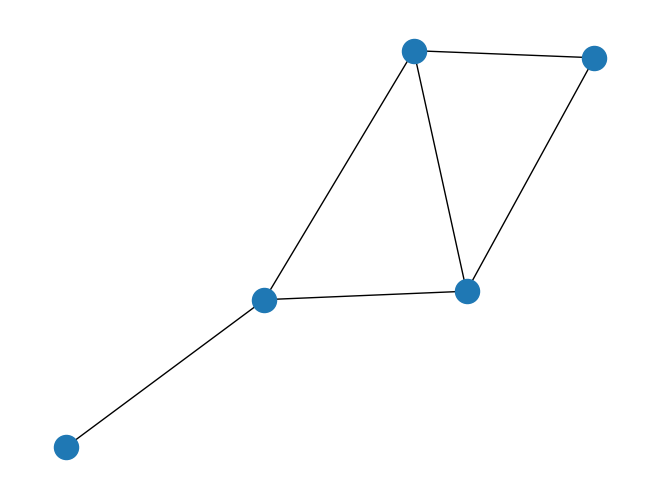

In [4]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4])
G.add_edges_from([(0, 1), (1, 2), (1, 3), (2, 3), (3, 4), (2, 4)])
nx.draw(G)

In [5]:
inst_E = [list(edge) for edge in G.edges]
color_num = 3
num_nodes = G.number_of_nodes()
instance_data = {"V": num_nodes, "N": color_num, "E": inst_E}
num_qubits = num_nodes * color_num

# Quantum Approximate Optimazation Algorithm (QAOA)
QAOA is one of the quantum optimization algorithms using variational quantum circuits. In JTQ, since QAOA is supported, it is relatively easy to execute QAOA.

First, we use JijModeling-Transpiler to create a CompiledInstance from the mathematical model and instance data of JijModeling.

In [6]:
compiled_instance = jtc.compile_model(problem, instance_data)

Next, we create a QAOABuilder using JTQ's transpile_to_qaoa_ansatz. By setting the number of repetitions for QAOA layers and the weight coefficients for constraints in this Builder, we can create the variational quantum circuit and Hamiltonian for QAOA.

In [7]:
qaoa_builder = jt_qu.qaoa.transpile_to_qaoa_ansatz(compiled_instance,normalize=False,relax_method=jtc.pubo.RelaxationMethod.SquaredPenalty)
qaoa_ansatz, hamiltonian, constant = qaoa_builder.get_qaoa_ansatz(
    p=1, multipliers={"one-color": 1}
)

Now that we have the variational quantum circuit and Hamiltonian ready, let's execute QAOA using quri_parts.

In [15]:
def run_qaoa(
    ansatz: LinearMappedUnboundParametricQuantumCircuit,
    hamiltonian: Operator,
    method: str | callable,
) -> OptimizeResult:
    def _cost_func(parameters, ansatz, hamiltonian, estimator):
        parametric_state = ParametricCircuitQuantumState(
            ansatz.qubit_count, ansatz
        )
        estimate = estimator(hamiltonian, parametric_state, parameters)
        return estimate.value.real

    initial_params = np.array([1.0] * ansatz.parameter_count)

    estimator = create_qulacs_vector_parametric_estimator()

    result = minimize(
        _cost_func,
        initial_params,
        args=(ansatz, hamiltonian, estimator),
        method=method)

    return result

In [16]:
result = run_qaoa(qaoa_ansatz, hamiltonian, "COBYLA")

We will try sampling the solution using the obtained variational parameters. Here, we are converting the results into a jm.SampleSet. By doing this, the solution is automatically transformed into the form formulated by the mathematical model, and it also calculates constraint violations and objective function values.

In [18]:
def sample_result(
    result: OptimizeResult,
    ansatz: LinearMappedUnboundParametricQuantumCircuit,
    num_qubits: int,
    num_shots: int = 1000,
) -> jm.SampleSet:
    bind_ansatz_opt = ansatz.bind_parameters(result.x)
    sampler = create_qulacs_vector_sampler()
    sampling_result = sampler(bind_ansatz_opt, num_shots)
    result_bits = {
        bin(key)[2:].zfill(num_qubits)[::-1]: val
        for key, val in sampling_result.items()
    }
    sampleset = qaoa_builder.decode_from_counts(result_bits)
    return sampleset

In [19]:
sampleset = sample_result(result, qaoa_ansatz, num_qubits)

In [20]:
sampleset.lowest()

SampleSet(record=Record(solution={'x': [(([1, 4, 0, 2, 3], [0, 0, 1, 1, 2]), [1.0, 1.0, 1.0, 1.0, 1.0], (5, 3))]}, num_occurrences=[1]), evaluation=Evaluation(energy=[], objective=[0.0], constraint_violations={"one-color": [0.0]}, constraint_forall={}, constraint_values=[], penalty={}), measuring_time=MeasuringTime(solve=SolvingTime(preprocess=None, solve=None, postprocess=None), system=SystemTime(post_problem_and_instance_data=None, request_queue=None, fetch_problem_and_instance_data=None, fetch_result=None, deserialize_solution=None), total=None), metadata={})

Finally, let's plot the results obtained from sampling.

In [21]:
def plot_graph_coloring(graph: nx.Graph, sampleset: jm.SampleSet):
    # extract feasible solution
    feasibles = sampleset.feasible()
    if feasibles.evaluation.objective.size == 0:
        print("No feasible solution found ...")
    else:
        objectives = np.array(feasibles.evaluation.objective)
        lowest_index = np.argmin(objectives)

        # get indices of x = 1
        indices, _, _ = feasibles.record.solution["x"][lowest_index]
        # get vertices and colors
        sorted_vertices, sorted_colors = zip(
            *sorted(zip(*indices), key=lambda x: x[1])
        )
        # initialize vertex color list
        node_colors = [-1] * len(sorted_vertices)
        # set color list for visualization
        colorlist = ["gold", "violet", "limegreen", "darkorange"]
        # set vertex color list
        for i, j in zip(sorted_vertices, sorted_colors):
            node_colors[i] = colorlist[j]
        # make figure
        nx.draw_networkx(graph, node_color=node_colors, with_labels=True)
        plt.show()

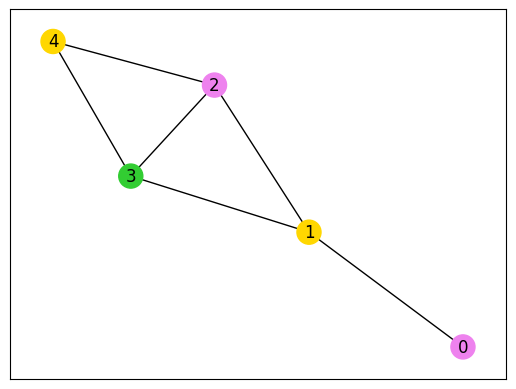

In [22]:
plot_graph_coloring(G, sampleset)

# Quantum Alternating Operator Ansatz
Next, let's try solving the graph coloring problem using the Quantum Alternating Operator Ansatz. The Quantum Alternating Operator Ansatz is a modification of QAOA, where the mixer is changed from an $X$-mixer to a mixer tailored to the problem, ensuring that only solutions satisfying the constraints are searched for. For more detailed information, please refer to the original paper. Here, we will look at how to implement it in JTQ.

For the Graph Coloring problem, there is a one-hot constraint:
$$
\sum_k x_{v,k} = 1\quad \forall v
$$
However, turning this into an $XY$-mixer is the Quantum Alternating Operator Ansatz approach to the Graph Coloring problem.

First, we prepare a mathematical model excluding the constraints.

In [23]:
def graph_coloring_problem_wo_onehot() -> jm.Problem:
    # define variables
    V = jm.Placeholder("V")
    E = jm.Placeholder("E", ndim=2)
    N = jm.Placeholder("N")
    x = jm.BinaryVar("x", shape=(V, N))
    n = jm.Element("i", belong_to=(0, N))
    v = jm.Element("v", belong_to=(0, V))
    e = jm.Element("e", belong_to=E)
    # set problem
    problem = jm.Problem("Graph Coloring without Onehot")
    # set one-hot constraint that each vertex has only one color
    problem += jm.sum([n, e], x[e[0], n] * x[e[1], n])
    return problem

In [24]:
problem = graph_coloring_problem_wo_onehot()
problem

Similar to before, we compile and create a QAOABuilder.

In [25]:
compiled_instance = jtc.compile_model(problem, instance_data)
qaoa_builder = jt_qu.qaoa.transpile_to_qaoa_ansatz(compiled_instance)

Earlier, we output the Ansatz as well, but here, since only the Ising Hamiltonian part is sufficient, we will just output the Hamiltonian.

In [26]:
ising_operator, _ = qaoa_builder.get_hamiltonian()

Let's write a function to add gates on top of the Pauli operators in the Hamiltonian.

In [27]:
def add_exp_operator_to_circuit(
    ansatz: LinearMappedUnboundParametricQuantumCircuit,
    parameter: Parameter,
    hamiltonian: Operator,
):
    for key, value in hamiltonian.items():
        if key != pauli_label({}):
            indexes, pauli_ids = key.index_and_pauli_id_list
            ansatz.add_ParametricPauliRotation_gate(
                indexes, pauli_ids, angle={parameter: value}
            )
    return ansatz

Next, we will create an $XY$-mixer. The $XY$-mixer can be written as
$$
XY_{ij} = \frac{1}{2}\left(X_iX_j + Y_iY_j \right).
$$
This is an operator that swaps the bits 1 and 0 in bit $i,j$. Therefore, it can transform a bit string $100$, which satisfies the one-hot constraint, into another bit string $010$, which also satisfies the one-hot constraint.

Here, the only part under the one-hot constraint is related to color, so in terms of the mathematical model, we need to transform the bits between $x_{v0}$ and $x_{v1}$.
On the other hand, as these variables are usually embedded in qubits, it is necessary to remember which bit corresponds to which variable when constructing the algorithm and handle them appropriately.
In JTQ, the correspondence of variables is contained in var_map inside CompiledInstance.
```python
var_map['variable_name'][indices]
```
You can check which qubit corresponds to a variable in the mathematical model in this way.
Let's use this to create an $XY$-mixer.

What we want here is the transformation between $x_{v,k}$ and $x_{v,k+1}$, so we can obtain the index of the corresponding qubit by accessing compiled_instance.var_map.var_map["x"][(i,k)]."

In [28]:
def xy_mixer_hamiltonian(
    num_nodes: int, num_colors: int, compiled_instance: jtc.CompiledInstance
):
    hamiltonian = Operator()
    var_map = compiled_instance.var_map.var_map["x"]
    for i in range(num_nodes):
        for k in range(0, num_colors - 1, 2):
            hamiltonian.add_term(
                pauli_label(f"X{var_map[(i,k)]} X{var_map[(i,k+1)]}"), 1 / 2
            )
            hamiltonian.add_term(
                pauli_label(f"Y{var_map[(i,k)]} Y{var_map[(i,k+1)]}"), 1 / 2
            )

    # odd
    for i in range(num_nodes):
        for k in range(1, num_colors - 1, 2):
            hamiltonian.add_term(
                pauli_label(f"X{var_map[(i,k)]} X{var_map[(i,k+1)]}"), 1 / 2
            )
            hamiltonian.add_term(
                pauli_label(f"Y{var_map[(i,k)]} Y{var_map[(i,k+1)]}"), 1 / 2
            )

    # ini-last
    if num_colors % 2 == 1:
        for i in range(num_nodes):
            hamiltonian.add_term(
                pauli_label(f"X{var_map[(i,0)]} X{var_map[(i,num_colors-1)]}"),
                1 / 2,
            )
            hamiltonian.add_term(
                pauli_label(f"Y{var_map[(i,0)]} Y{var_map[(i,num_colors-1)]}"),
                1 / 2,
            )

    return hamiltonian

In [29]:
def create_initial_state(
    ansatz: LinearMappedUnboundParametricQuantumCircuit,
    compiled_instance: jtc.CompiledInstance,
    num_nodes: int,
):
    var_map = compiled_instance.var_map.var_map["x"]
    for i in range(num_nodes):
        idx = var_map[(i, 0)]
        ansatz.add_X_gate(idx)
    return ansatz

In [30]:
def create_ansatz(
    num_layers: int,
    ising_operator: Operator,
    num_qubits: int,
    num_nodes: int,
    color_num: int,
    compiled_instance: jtc.CompiledInstance,
):
    mixer_hamiltonian = xy_mixer_hamiltonian(
        num_nodes, color_num, compiled_instance
    )
    ansatz = LinearMappedUnboundParametricQuantumCircuit(num_qubits)
    ansatz = create_initial_state(ansatz, compiled_instance, num_nodes)

    for p in range(num_layers):
        gamma, beta = ansatz.add_parameters(f"gamma_{p}", f"beta_{p}")
        ansatz = add_exp_operator_to_circuit(ansatz, gamma, ising_operator)
        ansatz = add_exp_operator_to_circuit(ansatz, beta, mixer_hamiltonian)
    return ansatz

Now that the Ansatz has been created, we would like to run the Quantum Alternating Operator Ansatz using this Ansatz.

In [31]:
ansatz = create_ansatz(
    1, ising_operator, num_qubits, num_nodes, color_num, compiled_instance
)

In [32]:
result = run_qaoa(ansatz, ising_operator, "COBYLA")

In [34]:
sampleset = sample_result(result, ansatz, num_qubits)

Let's plot the results obtained.

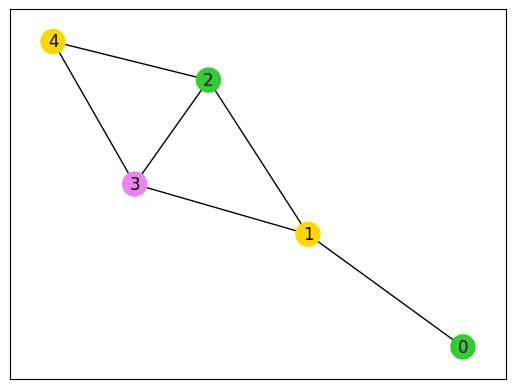

In [35]:
plot_graph_coloring(G, sampleset)

Finally, let's try solving a slightly larger problem.

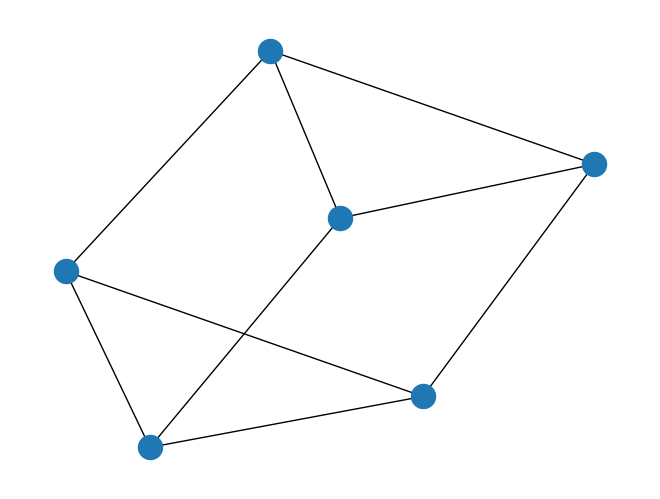

In [36]:
G = nx.Graph()
G.add_nodes_from([0, 1, 2, 3, 4, 5])
G.add_edges_from(
    [(0, 1), (0, 2), (0, 5), (1, 2), (1, 3), (2, 4), (3, 4), (3, 5), (4, 5)]
)
nx.draw(G)
inst_E = [list(edge) for edge in G.edges]
color_num = 3
num_nodes = G.number_of_nodes()
instance_data = {"V": num_nodes, "N": color_num, "E": inst_E}
num_qubits = num_nodes * color_num

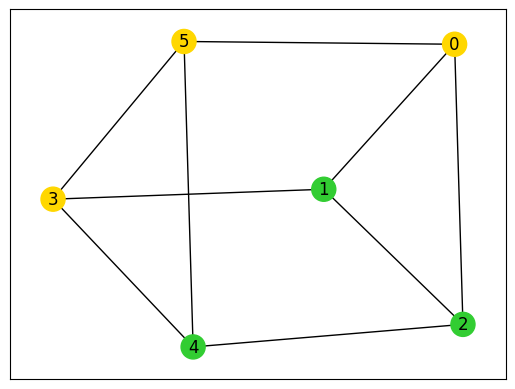

In [37]:
compiled_instance = jtc.compile_model(graph_coloring_problem(), instance_data)
qaoa_builder = jt_qu.qaoa.transpile_to_qaoa_ansatz(compiled_instance,normalize=False)
qaoa_ansatz, hamiltonian, constant = qaoa_builder.get_qaoa_ansatz(
    p=1, multipliers={"one-color": 1}
)
qaoa_result = run_qaoa(qaoa_ansatz, hamiltonian, "COBYLA")
qaoa_sampleset = sample_result(qaoa_result, qaoa_ansatz, num_qubits)
plot_graph_coloring(G, qaoa_sampleset)

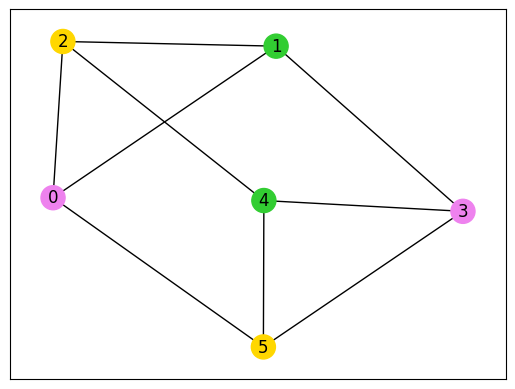

In [38]:
compiled_instance = jtc.compile_model(graph_coloring_problem_wo_onehot(), instance_data)
qaoa_builder = jt_qu.qaoa.transpile_to_qaoa_ansatz(compiled_instance,normalize=False)
ising_operator, _ = qaoa_builder.get_hamiltonian()
ansatz = create_ansatz(
    1, ising_operator, num_qubits, num_nodes, color_num, compiled_instance
)
alternating_result = run_qaoa(ansatz, ising_operator, "COBYLA")
alternating_sampleset = sample_result(alternating_result, ansatz, num_qubits)
plot_graph_coloring(G, alternating_sampleset)